In [ ]:
#!pip install carculator
#!pip list -v | grep carcu

In [2]:
import pandas as pd
import numpy as np
import carculator
from carculator import *
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

In [3]:
import os
from google.colab import drive
# path
drive.mount('/content/gdrive')
gdrive_path = '/content/gdrive/My Drive/02.22_FRQ_Mobilité_durable_IVEO/Project/Lit_review_resources/tools/carculator/'

Mounted at /content/gdrive


In [4]:
scope = {
            'size':['Van'],
            "year": [2020]
        }

cip = CarInputParameters()
cip.static()
dcts, array = fill_xarray_from_input_parameters(cip,  scope = scope)

In [5]:
mass_p = [x for x in cip.parameters if 'mass' in x]
#mass_p

In [6]:
cm = CarModel(array, cycle='WLTC')
cm.set_all()

mass-related parameters for BEV:

- component level:

battery cell mass
battery BoP mass
charger mass
combustion engine mass
combustion fixed mass
converter mass
electric engine mass
electric fixed mass
energy battery mass
glider base mass
inverter mass
power distribution unit mass
powertrain fixed mass
powertrain mass

- vehicle level:
curb mass
driving mass
total cargo mass

don't care about cargo mass, passenger mass

In [7]:
bev_mass_p = ["battery cell mass", "battery BoP mass", "charger mass", "combustion engine mass", "combustion fixed mass", "converter mass", "electric engine mass", "electric fixed mass",
              "energy battery mass", "glider base mass", "inverter mass", "power distribution unit mass", "powertrain fixed mass", "powertrain mass", "curb mass" ,"driving mass" ,"total cargo mass" ]

For BEV, total curb mass almost from glider base mass + energy battery mass, as it doesn't have comb. engine / ICEV powertrain

In [8]:
curb_m = (cm.array.sel(powertrain = "BEV", year = 2020, parameter="curb mass").values)
glider_m = (cm.array.sel(powertrain = "BEV", year = 2020, parameter="glider base mass").values)
battery_m = (cm.array.sel(powertrain = "BEV", year = 2020, parameter="energy battery mass").values)

print("total default BEV van curb mass is: %0.2f, glider base mass is: %0.2f, battery mass is %0.2f, \
      \n glider_mass accounts for about %0.2f of total curb mass" % (curb_m, glider_m, battery_m, ( glider_m/curb_m )))

######################## total curb mass < battery mass + glider mass because considering lightweighting factor for glider mass #####################

total default BEV van curb mass is: 1975.79, glider base mass is: 1400.00, battery mass is 580.00,       
 glider_mass accounts for about 0.71 of total curb mass


In [9]:
# to get all mass related parameters:
mass_value = []
mass_name = []
for m in bev_mass_p:
  try:
    mass_value.append(cm.array.sel(powertrain = "BEV", year = 2020, parameter=m).values)
    mass_name.append(cm.array.sel(powertrain = "BEV", year = 2020, parameter=m).parameter.values)
  except:
    pass

In [10]:
pd.DataFrame(list(zip(mass_name, mass_value)), columns =['Name', 'mass_value'])

Name     mass_value
0              battery cell mass      [[406.0]]
1               battery BoP mass      [[174.0]]
2                   charger mass    [[5.96087]]
3         combustion engine mass        [[0.0]]
4          combustion fixed mass        [[0.0]]
5                 converter mass   [[4.470652]]
6           electric engine mass  [[83.560936]]
7            electric fixed mass  [[19.347826]]
8            energy battery mass      [[580.0]]
9               glider base mass     [[1400.0]]
10                 inverter mass   [[8.941304]]
11  power distribution unit mass   [[3.973913]]
12         powertrain fixed mass  [[34.347828]]
13               powertrain mass   [[84.88075]]
14                     curb mass   [[1975.788]]
15                  driving mass   [[2115.788]]
16              total cargo mass      [[140.0]]

### Override default mass

Since battery mass and glider mass are the two major input to determine curb mass, we only change these two mass as other parts are trivial in BEV

override **calculated** parameters before  calling .set_all().

can override component mass, but not "curb mass"


using FORD F-150 platimum:
https://www.ford.ca/trucks/f150/f150-lightning/models/f150-platinum/

- Base Curb Weight Platinum:        	3130
- battery mass (incl. cell and BOP) (assumed data from GREET2): 1,031.85
- glider_base mass: 2,098.15

data sheet: "FORD_PUT"

In [11]:
cm1 = CarModel(array, cycle='WLTC')
#cm1.array.loc[dict(powertrain="BEV", year=2020, parameter="curb mass")] = 3130
cm1.array.loc[dict(powertrain="BEV", year=2020, parameter="glider base mass")] = 2098.15
cm1.array.loc[dict(powertrain="BEV", year=2020, parameter="energy battery mass")] = 1031.85    # already incl. "battery cell mass"+"battery BoP mass"
cm1.set_all()

f150_cm = cm1.array.sel(powertrain = "BEV", year = 2020, parameter="curb mass").values
f150_gm = cm1.array.sel(powertrain = "BEV", year = 2020, parameter="glider base mass").values
f150_bm = cm1.array.sel(powertrain = "BEV", year = 2020, parameter="energy battery mass").values

print("now, the new Ford F-150 BEV curb mass is: %0.2f, glider base mass is: %0.2f, battery mass is %0.2f, \
       " % (f150_cm, f150_gm, f150_bm))


now, the new Ford F-150 BEV curb mass is: 3092.83, glider base mass is: 2098.15, battery mass is 1031.85,        


### start calculation

#### A: result w/o changing the component mass, default Van BEV 2020

In [12]:
ic = InventoryCar(cm)
results = ic.calculate_impacts()

****************** IMPORTANT BACKGROUND PARAMETERS ******************
 * The country of use is CH.
 * Power and energy batteries produced in CN using ['NMC-622'] chemistry/ies
 * between 2020 and 2036, % of renewable: 78.0.
 * electrolysis is completed by smr - natural gas.
 	 * in 2020 _________________________________________ 0%
 * cng is completed by biogas - sewage sludge.
 	 * in 2020 _________________________________________ 22.0%
 * diesel is completed by biodiesel - cooking oil.
 	 * in 2020 _________________________________________ 5.0%
 * petrol is completed by bioethanol - wheat straw.
 	 * in 2020 _________________________________________ 1.0%
 * *********************************************************************


#### B: see the new results after changing the component mass

In [13]:
ic1 = InventoryCar(cm1)
results1 = ic1.calculate_impacts()

****************** IMPORTANT BACKGROUND PARAMETERS ******************
 * The country of use is CH.
 * Power and energy batteries produced in CN using ['NMC-622'] chemistry/ies
 * between 2020 and 2036, % of renewable: 78.0.
 * electrolysis is completed by smr - natural gas.
 	 * in 2020 _________________________________________ 0%
 * cng is completed by biogas - sewage sludge.
 	 * in 2020 _________________________________________ 22.0%
 * diesel is completed by biodiesel - cooking oil.
 	 * in 2020 _________________________________________ 5.0%
 * petrol is completed by bioethanol - wheat straw.
 	 * in 2020 _________________________________________ 1.0%
 * *********************************************************************


In [14]:
df = results.sel(powertrain = "BEV", year = 2020).to_dataframe('impact')
# adding in a new col to store results with the new mass
df["impact_new_mass"] = results1.sel(powertrain = "BEV", year = 2020).to_dataframe('impact')["impact"].values
df

powertrain  year  \
impact_category              size impact               value                    
GWP100a                      Van  glider               0            BEV  2020   
                                  powertrain           0            BEV  2020   
                                  energy storage       0            BEV  2020   
                                  energy chain         0            BEV  2020   
                                  maintenance          0            BEV  2020   
...                                                                 ...   ...   
non-renewable primary energy Van  maintenance          0            BEV  2020   
                                  EoL                  0            BEV  2020   
                                  road                 0            BEV  2020   
                                  direct - non-exhaust 0            BEV  2020   
                                  direct - exhaust     0            BEV  2020   

                                                                impact  \
impact_category              size impact               value             
GWP100a                      Van  glider               0      0.049877   
                                  powertrain           0      0.012050   
                                  energy storage       0      0.051448   
                                  energy chain         0      0.020438   
                                  maintenance          0      0.011601   
...                                                                ...   
non-renewable primary energy Van  maintenance          0      0.230888   
                                  EoL                  0      0.046106   
                                  road                 0      0.556120   
                                  direct - non-exhaust 0      0.000000   
                                  direct - exhaust     0      0.000000   

                                                              impact_new_mass  
impact_category              size impact               value                   
GWP100a                      Van  glider               0             0.074749  
                                  powertrain           0             0.014900  
                                  energy storage       0             0.091528  
                                  energy chain         0             0.024844  
                                  maintenance          0             0.018105  
...                                                                       ...  
non-renewable primary energy Van  maintenance          0             0.361056  
                                  EoL                  0             0.080470  
                                  road                 0             0.750700  
                                  direct - non-exhaust 0             0.000000  
                                  direct - exhaust     0             0.000000  

[207 rows x 4 columns]

In [ ]:
#save data

from google.colab import drive
# path
drive.mount('/content/gdrive')
gdrive_path = '/content/gdrive/My Drive/02.22_FRQ_Mobilité_durable_IVEO/Project/Lit_review_resources/tools/carculator/'


import os
fname = "FORD_PUT_new_mass" + ".xlsx"
fpath = os.path.join(gdrive_path, "trial_code/benchmark/figs_in_disc/mass/", "results/", fname)
df.to_excel(fpath )

Mounted at /content/gdrive


In [ ]:
# print out all 23 impact categories
#print((df.index.get_level_values(0).values))
#print([i for i in range(0, 207, 9)])

In [ ]:
#df.iloc[162:162+9,:].droplevel(level=1)

In [ ]:
#df.index.get_level_values(2).values
# select components for plotting
#df_sel_comp =  df[ (df.index.get_level_values(2).values == ['glider']) | (df.index.get_level_values(2).values == ['powertrain']) | (df.index.get_level_values(2).values == ['energy storage'])   ]
#df_sel_comp

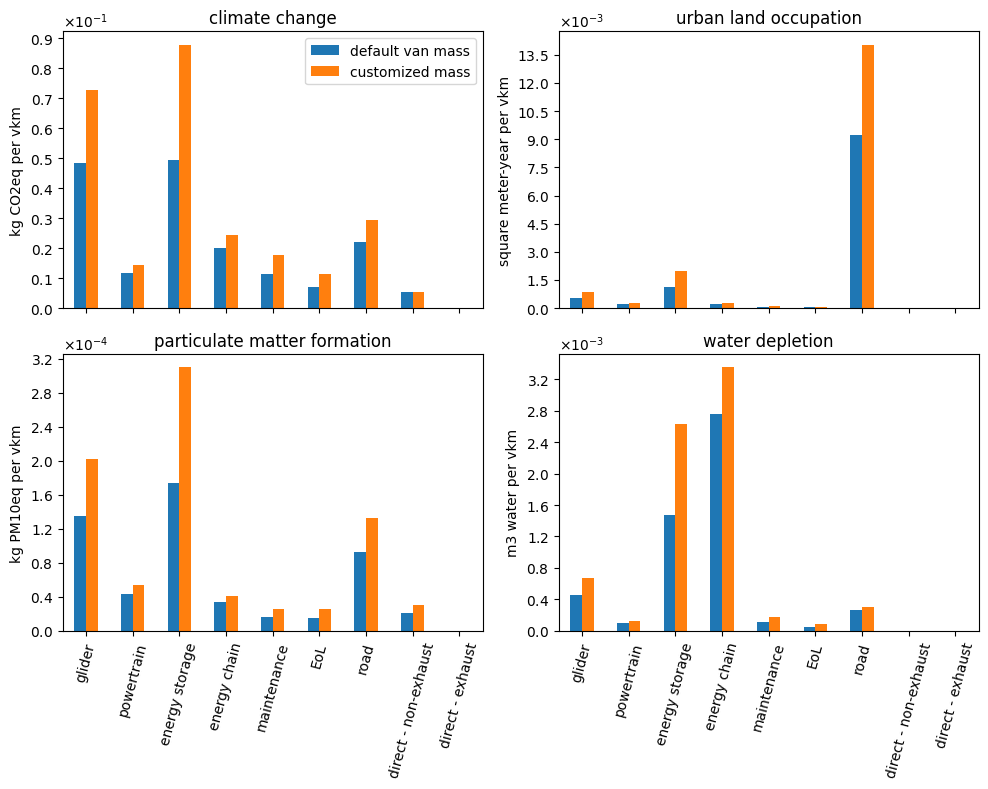

In [15]:
from matplotlib.ticker import ScalarFormatter, MaxNLocator

formatter_co2 = ScalarFormatter(useMathText=True)
formatter_co2.set_scientific(True)
formatter_co2.set_powerlimits((-1, -1))   #(-1, 0)
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))


fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, sharex = True, figsize = (10,8))
#GWP
df.iloc[63:63+9,:].plot.bar(ax=ax1, y = ["impact","impact_new_mass"],  legend=True, title = df.iloc[63:63+9,:].index[0][0]  )
legend = ax1.legend()
legend.get_texts()[0].set_text('default van mass')
legend.get_texts()[1].set_text('customized mass')
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
ax1.yaxis.set_major_formatter(formatter_co2)
ax1.set_ylabel('kg CO2eq per vkm')
#land
df.iloc[153:153+9,:].plot.bar(ax=ax2, y = ["impact","impact_new_mass"], legend=False, title =  df.iloc[153:153+9,:].index[0][0]  )
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

ax2.yaxis.set_major_formatter(formatter)
ax2.set_ylabel('square meter-year per vkm')

#PM
df.iloc[126:126+9,:].plot.bar(ax=ax3, y = ["impact","impact_new_mass"], legend=False, title =  df.iloc[126:126+9,:].index[0][0] )
ax3.yaxis.set_major_locator(MaxNLocator(integer=True))
ax3.yaxis.set_major_formatter(formatter)
ax3.set_ylabel('kg PM10eq per vkm')


#WDP
df.iloc[162:162+9,:].plot.bar(ax=ax4, y = ["impact","impact_new_mass"], legend=False, title =  df.iloc[162:162+9,:].index[0][0]   )
ax3.set_xticklabels(['glider', 'powertrain', 'energy storage', 'energy chain', 'maintenance', 'EoL', 'road', 'direct - non-exhaust','direct - exhaust'], rotation=75)
ax4.set_xticklabels(['glider', 'powertrain', 'energy storage', 'energy chain', 'maintenance', 'EoL', 'road', 'direct - non-exhaust','direct - exhaust'], rotation=75)
ax4.set_ylabel('m3 water per vkm')
ax4.yaxis.set_major_locator(MaxNLocator(integer=True))
ax4.yaxis.set_major_formatter(formatter)

ax3.set_xlabel(xlabel="")
ax4.set_xlabel(xlabel="")


plt.tight_layout()

#save fig:
fname = "FORD_PUT_new_mass" + ".png"
fpath = os.path.join(gdrive_path, "trial_code/benchmark/figs_in_disc/mass/", "results/", fname)

plt.savefig(fpath, format='png', dpi=300)